In [1]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

from scipy.linalg import expm
from scipy.linalg import null_space

from general_graph_utils import *

Attempt 1

In [2]:
def affinity(k12,k21,k23,k32,k31,k13):
    aff = np.log((k12*k23*k31)/(k13*k32*k21))
    return aff

In [3]:
# Transition rate matrix W
def transition_matrix(k12,k21,k23,k32,k31,k13):
    W = np.array([
        [-k12 - k13, k21, k31],  # Transition rates from E1
        [k12, -k21 - k23, k32],  # Transition rates from E2
        [k13, k23, -k31 - k32],  # Transition rates from E3
    ])
    return W

In [4]:
# Compute the stationary distribution pi
def stationary_distribution(W):
    W_T = W.T
    pi = null_space(W_T).flatten()
    pi /= np.sum(pi)  # Normalize to ensure sum(pi) = 1
    return pi

In [5]:
# Function to compute the correlation function C(t)
def correlation_function(t, W, pi):
    exp_Wt = expm(W * t)  # Compute the matrix exponential e^(Wt)
    return np.dot(exp_Wt[0], pi)  # e^(Wt)[1j] * pi[j] summed over j

All rates = 1.0

In [76]:
# Parameters for the unicyclic network (from the paper's description)
# Rates are chosen to create oscillations similar to those in the paper
k12, k21 = 1.0, 1.0  # Rates between E1 and E2
k23, k32 = 1.0, 1.0  # Rates between E2 and E3
k31, k13 = 1.0, 1.0  # Rates between E3 and E1

print(affinity(k12,k21,k23,k32,k31,k13))

W = transition_matrix(k12,k21,k23,k32,k31,k13)
pi = stationary_distribution(W)
eigvals, eigvecs = scipy.linalg.eig(W)
print(eigvals)

x_i = eigvals[1].imag
x_r = eigvals[1].real
R = x_i/x_r
print(R/2*math.pi)

# Time points for the plot
times = np.linspace(0, 10, 500)  # Time from 0 to 10 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W, pi) for t in times]

0.0
[-3.0000000e+00+0.j  4.4408921e-16+0.j -3.0000000e+00+0.j]
0.0


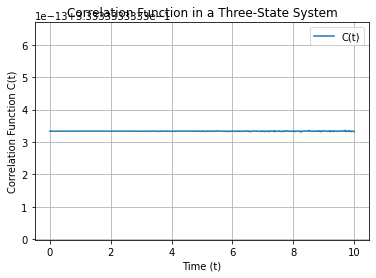

In [7]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

$\mathcal{A}$ = 1.0

In [77]:
# Define the transition rate matrix W
# Rates: k_ij is the rate from state i to state j
k12, k21 = 1.0, 2.0  # Rates between E1 and E2
k23, k32 = 1.5, 1.0  # Rates between E2 and E3
k31, k13 = 2.0, 0.5  # Rates between E3 and E1

print(affinity(k12,k21,k23,k32,k31,k13))

W = transition_matrix(k12,k21,k23,k32,k31,k13)
pi = stationary_distribution(W)
eigvals, eigvecs = scipy.linalg.eig(W)
print(eigvals)

x_i = np.abs(eigvals[1].imag)
x_r = np.abs(eigvals[1].real)
R = x_i/x_r
print(R/2*math.pi)

# Time points for the plot
times = np.linspace(0, 10, 500)  # Time from 0 to 10 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W, pi) for t in times]

1.0986122886681098
[ 4.4408921e-16+0.j -3.5000000e+00+0.j -4.5000000e+00+0.j]
0.0


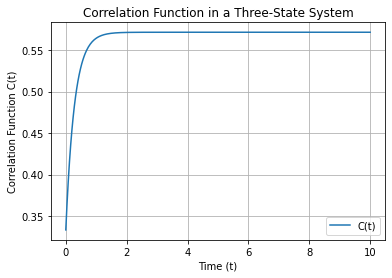

In [48]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

Oscillatory transition rates

In [78]:
# Oscillatory transition rates
k12, k21 = 1.0, 0.5  # Rates between E1 and E2
k23, k32 = 1.5, 0.2  # Rates between E2 and E3
k31, k13 = 2.0, 0.1  # Rates between E3 and E1

print(affinity(k12,k21,k23,k32,k31,k13))

W = transition_matrix(k12,k21,k23,k32,k31,k13)
pi = stationary_distribution(W)
eigvals, eigvecs = scipy.linalg.eig(W)
print(eigvals)

x_i = np.abs(eigvals[1].imag)
x_r = np.abs(eigvals[1].real)
R = x_i/x_r
print(R/2*math.pi)

# Time points for the plot
times = np.linspace(0, 10, 500)  # Time from 0 to 10 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W, pi) for t in times]

5.703782474656201
[-3.18595413e-16+0.j         -2.65000000e+00+0.99874922j
 -2.65000000e+00-0.99874922j]
0.5920119255341094


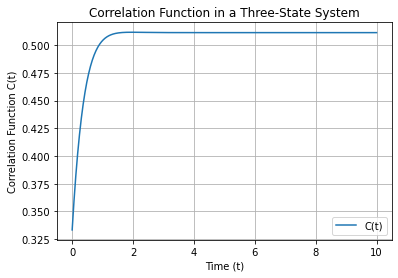

In [51]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

Eigenvalues complex

In [79]:
# Oscillatory transition rates
k13, k12, k23, k21, k31, k32 = 0.10536, 0.00158, 0.00805, 0.06794, 0.03089, 0.08335

print(affinity(k12,k21,k23,k32,k31,k13))

W = transition_matrix(k12,k21,k23,k32,k31,k13)
pi = stationary_distribution(W)
eigvals, eigvecs = scipy.linalg.eig(W)
print(eigvals)

x_i = np.abs(eigvals[1].imag)
x_r = np.abs(eigvals[1].real)
R = x_i/x_r
print(R/2*math.pi)

# Time points for the plot
times = np.linspace(0, 100, 500)  # Time from 0 to 10 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W, pi) for t in times]

-7.325527183964429
[-1.48585000e-01+0.05398063j -1.48585000e-01-0.05398063j
  2.38637456e-17+0.j        ]
0.5706671345841586


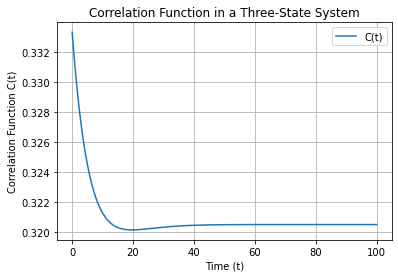

In [58]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

Totally away from equilibrium (unidirectional)

In [80]:
# Oscillatory transition rates
k12, k21 = 1.0, 0  # Rates between E1 and E2
k23, k32 = 1.5, 0  # Rates between E2 and E3
k31, k13 = 2.0, 0  # Rates between E3 and E1

W = transition_matrix(k12,k21,k23,k32,k31,k13)
pi = stationary_distribution(W)
eigvals, eigvecs = scipy.linalg.eig(W)
print(eigvals)

x_i = np.abs(eigvals[1].imag)
x_r = np.abs(eigvals[1].real)
R = x_i/x_r
print(R/2*math.pi)

# Time points for the plot
times = np.linspace(0, 10, 500)  # Time from 0 to 10 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W, pi) for t in times]

[-1.4637965e-16+0.j         -2.2500000e+00+1.19895788j
 -2.2500000e+00-1.19895788j]
0.8370305045274221


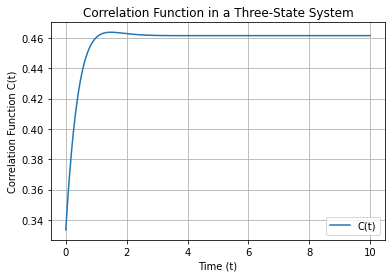

In [55]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

In [85]:
# Oscillatory transition rates
k12, k21 = 2.0, 1.0  # Rates between E1 and E2
k23, k32 = 2.0, 1.0  # Rates between E2 and E3
k31, k13 = 2.0, 1.0  # Rates between E3 and E1

print(affinity(k12,k21,k23,k32,k31,k13))

W = transition_matrix(k12,k21,k23,k32,k31,k13)
pi = stationary_distribution(W)
eigvals, eigvecs = scipy.linalg.eig(W)
print(eigvals)

x_i = np.abs(eigvals[1].imag)
x_r = np.abs(eigvals[1].real)
R = x_i/x_r
print(R/2*math.pi)

# Time points for the plot
times = np.linspace(0, 100, 500)  # Time from 0 to 10 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W, pi) for t in times]

2.0794415416798357
[ 3.53096146e-16+0.j        -4.50000000e+00+0.8660254j
 -4.50000000e+00-0.8660254j]
0.3022998940390361


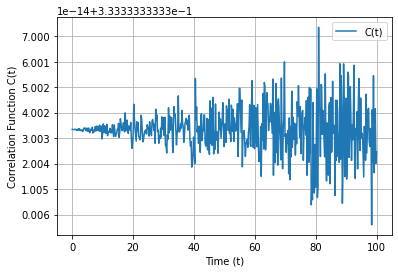

In [86]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
#plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

What parameter sets give you complex eigenvalues?

In [23]:
G = nx.DiGraph()
G_size = 3
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

G.add_edge(1,3)
G.add_edge(3,1)
G.add_edge(2,3)
G.add_edge(3,2)
G.add_edge(1,2)
G.add_edge(2,1)


G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 3)
G_ud.add_edge(3, 1)

In [24]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [25]:
label_dict, label_list = get_labels(G)

In [26]:
label_dict

{(1, 3): 0.00855,
 (1, 2): 261.10205,
 (2, 3): 70.46691,
 (2, 1): 1.61796,
 (3, 1): 88.32234,
 (3, 2): 461.97379}

In [27]:
all_labels = np.zeros((1000,6))
all_eigvals_real = np.zeros((1000,3))
all_eigvals_complex = np.zeros((1000,3))
all_affinities = np.zeros((1000,1))

In [28]:
for i in range(1000):
    label_dict, label_list = get_labels(G)
    all_labels[i] = label_list
    cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f, products_b, cycle_list)
    all_affinities[i] = total_affinities
    L = Laplacian_all(edge_list,label_list,node_list)
    eigvals, eigvecs = scipy.linalg.eig(L)
    eigvals_sorted = np.sort(eigvals)
    all_eigvals_real[i] = eigvals_sorted.real
    all_eigvals_complex[i] = eigvals_sorted.imag

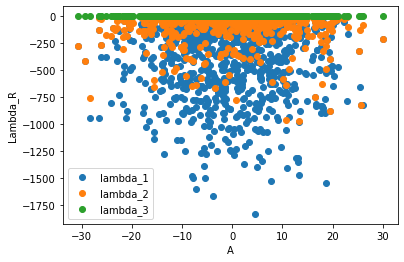

In [29]:
plt.scatter(all_affinities, all_eigvals_real[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_real[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_real[:,2], label='lambda_3')
plt.xlabel('A')
plt.ylabel('Lambda_R')
plt.legend()

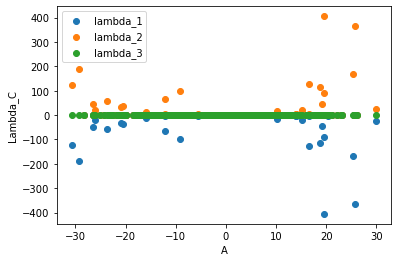

In [30]:
plt.scatter(all_affinities, all_eigvals_complex[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_complex[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_complex[:,2], label='lambda_3')
plt.xlabel('A')
plt.ylabel('Lambda_C')
plt.legend()

Find a parameter set that has complex eigenvalues and a particular affinity.

In [31]:
np.nonzero(all_eigvals_complex)

(array([  9,   9,  64,  64, 124, 124, 130, 130, 148, 148, 160, 160, 210,
        210, 230, 230, 314, 314, 319, 319, 349, 349, 404, 404, 410, 410,
        466, 466, 545, 545, 548, 548, 571, 571, 580, 580, 602, 602, 607,
        607, 667, 667, 691, 691, 755, 755, 761, 761, 793, 793, 811, 811,
        824, 824, 861, 861, 868, 868, 897, 897, 912, 912, 954, 954, 973,
        973]),
 array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]))

In [92]:
all_affinities[580]

array([13.91310139])

In [93]:
all_eigvals_complex[580]

array([-3.04061353,  3.04061353,  0.        ])

In [97]:
all_labels[580,:]

array([0.88038, 0.04332, 0.74086, 1.90919, 2.94427, 4.36796])

Attempt 2

In [76]:
k_1p = 1.0
k_1m = 1.0
k_2p = math.e**20
k_2m = 1.0
k_3p = 1.0
k_3m = 1.0

In [77]:
aff = np.log((k_1p*k_2p*k_3p)/(k_1m*k_2m*k_3m))
aff

20.0

In [78]:
L = np.array([[-k_1p-k_1m, k_2m, k_3m], [k_1m, -k_2p-k_2m, k_3p], [k_1p, k_2p, -k_3p-k_3m]])
scipy.linalg.expm(L*250)

array([[3.33333762e-01, 3.33333761e-01, 3.33333761e-01],
       [2.06115626e-09, 2.06115625e-09, 2.06115625e-09],
       [6.66667519e-01, 6.66667517e-01, 6.66667517e-01]])

In [79]:
eigvals, eigvecs = scipy.linalg.eig(L)
eigvals

array([-4.85165197e+08+0.j, -3.00000000e+00+0.j,  2.20656826e-14+0.j])

In [80]:
ss = eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)
ss

array([3.33333333e-01, 2.06115361e-09, 6.66666665e-01])

In [81]:
t = np.around(np.arange(0.1,250.0,step=.01), decimals = 2)

In [82]:
list_result = list(map(lambda i: scipy.linalg.expm(L*i), t))

In [83]:
P_0 = np.array([1,0,0])

new_list = np.zeros((len(t),3))

for i in range(len(t)):
    new_list[i] = ((list_result[i]*P_0)[0])[0]

In [84]:
print(new_list[0])
print(new_list[-1])

[0.82721215 0.82721215 0.82721215]
[0.33333196 0.33333196 0.33333196]


Text(0, 0.5, 'C_1,1(t)')

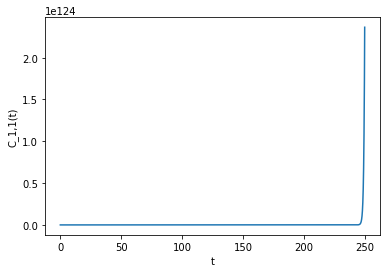

In [44]:
plt.plot(t, new_list[:,1])
plt.xlabel('t')
plt.ylabel('C_1,1(t)')
#plt.legend()

More formal workflow

In [57]:
G = nx.DiGraph()
G_size = 3
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

G.add_edge(1,3, weight = k_1m)
G.add_edge(3,1, weight = k_3p)
G.add_edge(2,3, weight = k_2p)
G.add_edge(3,2, weight = k_3m)
G.add_edge(1,2, weight = k_1p)
G.add_edge(2,1, weight = k_2m)

G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 3)
G_ud.add_edge(3, 1)

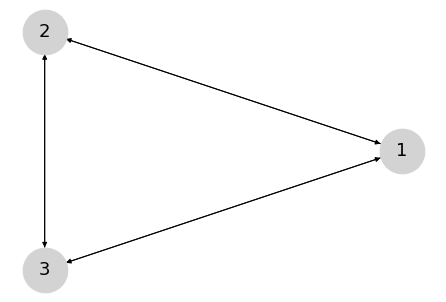

In [58]:
node_labels = {}
node_labels[1] = "1"
node_labels[2] = "2"
node_labels[3] = "3"
nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')

Next, we calculate some data structures encoding information about the graph.

In [59]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [60]:
label_dict, label_list = get_labels(G)

In [61]:
label_dict

{(1, 3): 1.0,
 (1, 2): 4.607186634331275e+28,
 (2, 3): 4.607186634331275e+28,
 (2, 1): 1.0,
 (3, 1): 4.607186634331275e+28,
 (3, 2): 1.0}

In [62]:
label_list

array([1.00000000e+00, 4.60718663e+28, 4.60718663e+28, 1.00000000e+00,
       4.60718663e+28, 1.00000000e+00])

Then, we calculate the cycle affinity using the general graphs framework (overkill for the 3-vertex graph, but it works).

In [63]:
cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)

In [64]:
products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
total_affinities = calculate_affinities(products_f, products_b, cycle_list)
print(total_affinities)

[198.]


For fun, we can calculate the steady state distribution using the spectrum of the Laplacian.

In [65]:
L = Laplacian_all(edge_list,label_list,node_list)
pi = steady_state_spectrum(L)

In [66]:
L

array([[-4.60718663e+28,  4.60718663e+28,  1.00000000e+00],
       [ 1.00000000e+00, -4.60718663e+28,  4.60718663e+28],
       [ 4.60718663e+28,  1.00000000e+00, -4.60718663e+28]],
      dtype=float128)

Let's grab the eigenvalues and eigenvectors of the Laplacian matrix.

In [39]:
eigvals, eigvecs = scipy.linalg.eig(L)

In [40]:
eigvals

array([-6.91077995e+28+3.98994067e+28j, -6.91077995e+28-3.98994067e+28j,
       -6.55378477e+12+0.00000000e+00j])

In [41]:
eigvecs

array([[-0.28867513+0.5j, -0.28867513-0.5j, -0.57735027+0.j ],
       [-0.28867513-0.5j, -0.28867513+0.5j, -0.57735027+0.j ],
       [ 0.57735027+0.j ,  0.57735027-0.j , -0.57735027+0.j ]])

Calculate the correlation function $C_{1,1}(t)$

In [42]:
t = np.around(np.arange(100.0,250.0,step=.01), decimals = 2)

In [43]:
list_result = list(map(lambda i: scipy.linalg.expm(L*i), t))

/Users/sabinahaque/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/matfuncs.py:437: RuntimeWarning: overflow encountered in longdouble_scalars
  self._d10_exact = _onenorm(self.A10)**(1/10.)


In [44]:
L

array([[-4.60718663e+28,  4.60718663e+28,  1.00000000e+00],
       [ 1.00000000e+00, -4.60718663e+28,  4.60718663e+28],
       [ 4.60718663e+28,  1.00000000e+00, -4.60718663e+28]],
      dtype=float128)

In [45]:
list_result = list(map(lambda i: scipy.linalg.expm(L*i), t))

P_0 = np.array([1,0,0])

new_list = np.zeros((len(t),3))

for i in range(len(t)):
    new_list[i] = ((list_result[i]*P_0)[0])[0]

/var/folders/ch/f1rl6h5x4fx2wbg2_f5bj5dw0000gn/T/ipykernel_8972/908813237.py:8: RuntimeWarning: invalid value encountered in multiply
  new_list[i] = ((list_result[i]*P_0)[0])[0]


In [46]:
new_list[0]

array([inf, inf, inf])

In [47]:
((L*P_0)[:,0])

array([-4.60718663e+28,  1.00000000e+00,  4.60718663e+28], dtype=float128)

Text(0, 0.5, 'C_1,1(t)')

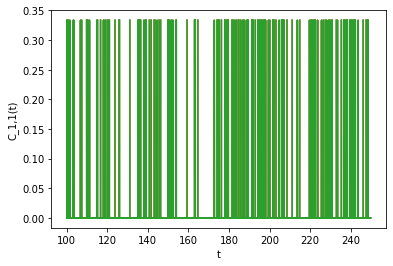

In [50]:
plt.plot(t, new_list)
plt.xlabel('t')
plt.ylabel('C_1,1(t)')
#plt.legend()